# Neural Networks and Deep Learning - Homework 1: Supervised Learning
## Classification Task
## Rosset Lorenzo, mat. 2021859

In [1]:
!git clone https://github.com/rossetl/NNDL.git
%cd NNDL/Homework\ 1

Cloning into 'NNDL'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 64 (delta 13), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.
/content/NNDL/Homework 1


In [2]:
from re import I
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from sklearn.model_selection import KFold

In [3]:
BATCHSIZE = 10
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', DEVICE)

Training device: cuda


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.), (1.))]) # try to change this

train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



In [5]:
train_size = 7000
val_size = 3000
test_size = 3000

train_subset = SubsetRandomSampler(np.arange(train_size))
val_subset = SubsetRandomSampler(np.arange(train_size, train_size + val_size))
test_subset = SubsetRandomSampler(np.arange(test_size))

train_dataloader = DataLoader(train_dataset, sampler=train_subset, batch_size=BATCHSIZE, shuffle=False, num_workers=1)
val_dataloader = DataLoader(train_dataset, sampler=val_subset, batch_size=BATCHSIZE, shuffle=False, num_workers=1)
test_dataloader = DataLoader(test_dataset, sampler=test_subset, batch_size=1, shuffle=False, num_workers=1)

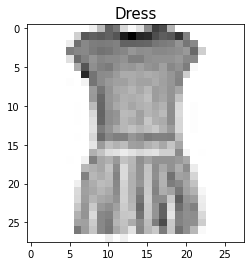

In [6]:
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def imshow(img, title):
    npimg = img.numpy()[0]
    plt.imshow(npimg, cmap='Greys')
    plt.title(title, size=15)
    plt.show()

idx = 3
imshow(train_dataset[idx][0], classes[train_dataset[idx][1]])

## Simple Convolutional Network

In [ ]:
class Conv_net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(12*4*4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
conv_net = Conv_net().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr=1e-3)

In [7]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss = []
    model.train()
    for sample_batched in dataloader:
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        out = model(x_batch)
        loss = loss_fn(out, label_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    return np.mean(train_loss)

def val_epoch(model, device, dataloader, loss_fn):
    val_loss = []
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for sample_batched in dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            out = model(x_batch)
            _, predicted = torch.max(out.data, 1)
            total += label_batch.size(0)
            correct += (predicted == label_batch).sum().item()
            loss = loss_fn(out, label_batch)
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    accuracy = 100 * correct / total
    return np.mean(val_loss), accuracy

# Compute the accuracy over the test set
def compute_accuracy(model, device, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for sample_batched in dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            out = model(x_batch)
            _, predicted = torch.max(out.data, 1)
            total += label_batch.size(0)
            correct += (predicted == label_batch).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
num_epochs = 50
train_loss_log = []
val_loss_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(conv_net, DEVICE, train_dataloader, loss_fn, optimizer)
    train_loss_log.append(train_loss)

    val_loss, accuracy = val_epoch(conv_net, DEVICE, val_dataloader, loss_fn)
    val_loss_log.append(val_loss)

    print('Epoch {:}/{:}, avg train loss: {:.3f}, avg test loss: {:.3f}, accuracy: {:.3f}%'.format(epoch + 1, num_epochs, train_loss, val_loss, accuracy))

test_accuracy = compute_accuracy(conv_net, DEVICE, test_dataloader)

Epoch 1/50, avg train loss: 0.932, avg test loss: 0.670, accuracy: 74.000%
Epoch 2/50, avg train loss: 0.622, avg test loss: 0.620, accuracy: 76.000%
Epoch 3/50, avg train loss: 0.557, avg test loss: 0.545, accuracy: 77.000%
Epoch 4/50, avg train loss: 0.494, avg test loss: 0.518, accuracy: 80.000%
Epoch 5/50, avg train loss: 0.459, avg test loss: 0.508, accuracy: 81.000%
Epoch 6/50, avg train loss: 0.423, avg test loss: 0.500, accuracy: 80.000%
Epoch 7/50, avg train loss: 0.393, avg test loss: 0.455, accuracy: 84.000%
Epoch 8/50, avg train loss: 0.365, avg test loss: 0.465, accuracy: 83.000%
Epoch 9/50, avg train loss: 0.348, avg test loss: 0.424, accuracy: 84.000%
Epoch 10/50, avg train loss: 0.325, avg test loss: 0.448, accuracy: 83.000%
Epoch 11/50, avg train loss: 0.307, avg test loss: 0.471, accuracy: 83.000%
Epoch 12/50, avg train loss: 0.291, avg test loss: 0.476, accuracy: 83.000%
Epoch 13/50, avg train loss: 0.275, avg test loss: 0.450, accuracy: 84.000%
Epoch 14/50, avg trai

Accuracy over the test set: 84.767


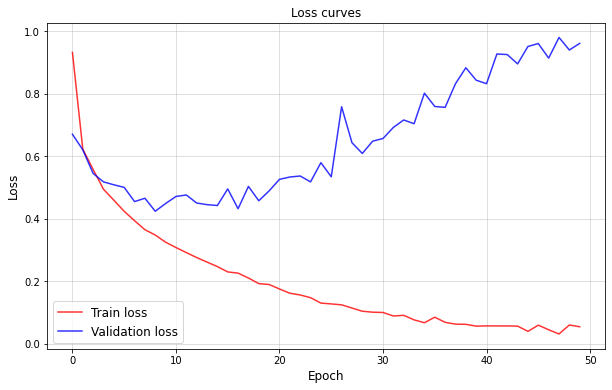

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, c='red', label='Train loss', alpha=0.8)
plt.plot(val_loss_log, c='blue', label='Validation loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

print('Accuracy over the test set: {:.3f}'.format(test_accuracy))

## Adding regularization and Hyperparameters Optimization

In [ ]:
%pip install optuna
import optuna
from optuna.trial import TrialState

In [ ]:
class build_model(nn.Module):

    def __init__(self, params):
        super().__init__()
        
        assert np.any(params['kernel_size'] % 2 == 1), 'Kernel sizes must be odd!'
        
        # Convolutional layers
        conv_layers = []
        in_channels = 1
        out_size = 28
        for i in range(2):
            conv_layers.append(nn.Conv2d(in_channels,
                                         params['out_channels'][i],
                                         params['kernel_size'][i]))
            out_size -= (params['kernel_size'][i] - 1)
            conv_layers.append(nn.Dropout2d(params['p_conv'][i]))
            conv_layers.append(nn.MaxPool2d(2, 2))
            conv_layers.append(nn.ReLu())
            out_size /= 2
            in_channels = params['out_channels'][i]
        self.conv_layers = nn.Sequential(*conv_layers)

        # Fully connected layers
        fc_layers = []
        in_features = params['out_channels'][-1] * out_size * out_size
        for i in range(2):
            fc_layers.append(nn.Linear(in_features, params['out_features'][i]))
            fc_layers.append(nn.Dropout(params['p_fc'][i]))
            fc_layers.append(nn.ReLU())
            in_features = params['out_features'][i]
        fc_layers.append(nn.Linear(in_features, 10))
        self.fc_layers = nn.Sequential(*fc_layers)
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = nn.Flatten(x)
        x = self.fc_layers(x)
        return x

def objective(trial):
    params = {
        'out_channels' : [trial.suggest_int(f'out_channels_conv0', 4, 6),
                          trial.suggest_int(f'out_channels_conv1', 4, 6)],
        'kernel_size' : [trial.suggest_int(f'kernel_size_conv0', 3, 7, step=2),
                         trial.suggest_int(f'kernel_size_conv1', 3, 7, step=2)],
        'p_conv' : [trial.suggest_float(f'dropout_conv0', 0., 0.5),
                    trial.suggest_float(f'dropout_conv0', 0., 0.5)],
        'out_features' : [trial.suggest_int(f'out_features_fc0', 30, 200),
                          trial.suggest_int(f'out_features_fc1', 30, 200)],
        'p_fc' : [trial.suggest_float(f'dropout_fc0', 0., 0.5),
                  trial.suggest_float(f'dropout_fc1', 0., 0.5)]
    }

    model = build_model(params)
    